In [1]:
import os
import pandas as pd
import numpy as np
import pandas_gbq
import unidecode

In [2]:
from google.cloud import bigquery

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='#'

In [4]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print(__version__) # requires version >= 1.9.0

4.9.0


In [5]:
import cufflinks as cf

In [6]:
init_notebook_mode(connected=True)

In [7]:
cf.go_offline()

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [75]:
import requests
import yaml

In [76]:
import firebase_admin
#Firbease (pip install firebase_admin)
from firebase_admin import credentials
from firebase_admin import firestore

In [ ]:
filename='#'

### ANALYCEMOS CUENTAS

In [9]:
sql = """
    SELECT *
    FROM `oan-nikarit.contoan.accounting`
"""

# Run a Standard SQL query using the environment's default project
df = pd.read_gbq(sql, dialect='standard')

Downloading: 100%|██████████| 1436/1436 [00:01<00:00, 989.19rows/s]


In [11]:
cuentas = pd.read_csv('cuentas.csv',index_col=0).to_dict()['NOMBRE']

In [12]:
projectos = pd.read_csv('projectos.csv',index_col=0).to_dict()['TITULO']

In [42]:
#df['month']=pd.DatetimeIndex(df['execution_date']).month

In [43]:
#df['day']=pd.DatetimeIndex(df['execution_date']).day

In [56]:
df['month_day']=df['execution_date'].apply(lambda x: str(x)[5:10])

In [13]:
df['proyecto']=df['project'].apply(lambda x: projectos[x])
df['inter']=df['intervention'].apply(lambda x: projectos[x])

In [14]:
df['proyecto'].value_counts()

Nikarit                   1080
Administration_general     136
Pompes d'eau                82
Fassol                      46
ADSAN                       37
Emancipacion                26
Forum Nikki                 18
CPNPF                        6
Évènements                   3
Aguapp                       2
Name: proyecto, dtype: int64

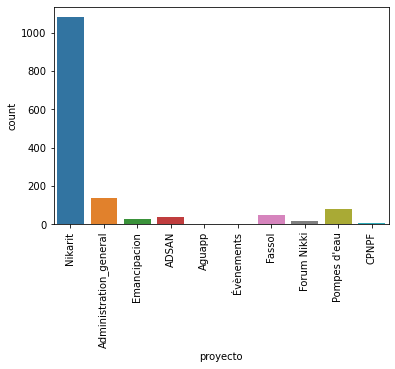

In [15]:
sns.countplot(x='proyecto',data=df)
plt.xticks(rotation=90)
plt.show()

In [16]:
df['cuenta_destino']=df['target_id'].apply(lambda x: cuentas[x])

In [17]:
df['categoria']=df['account_id'].apply(lambda x: cuentas[x])

In [18]:
df['cuenta_destino'].value_counts()

Banco Stripe                  553
Banco Paypal                  245
Banco Caja de Ingenieros      193
Caja Mireille                 114
Banco Santander               103
Caja Hafiz                     55
Caja Kader                     45
Caja                           44
Caja Abour Rhaman              29
Caja Rasak                     24
Deudas a c.p. (Acreedores)      6
Bank of Africa                  6
Deudas a c.p. (Deudores)        5
Caja Younous                    5
Caja Sofia                      2
Caja Imorou                     2
Caja Jaume                      2
Caja Sianson                    1
Caja Daniel                     1
Caja Habirou                    1
Name: cuenta_destino, dtype: int64

In [19]:
df['origin'].value_counts()

script_dani    861
contoan        427
g_forms        136
shopify         12
Name: origin, dtype: int64

In [20]:
usuarios = pd.read_csv('usuarios.csv',index_col=0).to_dict()['NOMBRE']

In [21]:
df['usuarios']=df['creator_user'].apply(lambda x: usuarios[x])

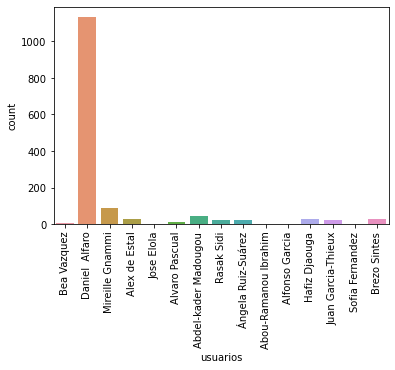

In [22]:
sns.countplot(x='usuarios',data=df)
plt.xticks(rotation=90)
plt.show()

## NIKARIT

In [23]:
df.columns

Index(['concept', 'place', 'creation_date', 'vat', 'description', 'amount',
       'id', 'phase', 'creator_user', 'execution_date', 'user_in_charge',
       'origin', 'account_id', 'project', 'code', 'type', 'intervention',
       'target_id', 'vat_amount', 'receipt', 'proyecto', 'inter',
       'cuenta_destino', 'categoria', 'usuarios'],
      dtype='object')

In [58]:
df_nikarit = df[df['proyecto']=='Nikarit']

In [25]:
df_nik_cat=df_nikarit.groupby(['categoria','type','inter'])['amount'].sum().reset_index()

In [26]:
df_nik_cat.head(2)

,categoria,type,inter,amount
0,Alquileres (oficinas y otros),expense,Espagne General 2020,199.65
1,Apertura,movement,Espagne General 2020,12102.71


In [27]:
expense = df_nik_cat[df_nik_cat['type']=='expense']

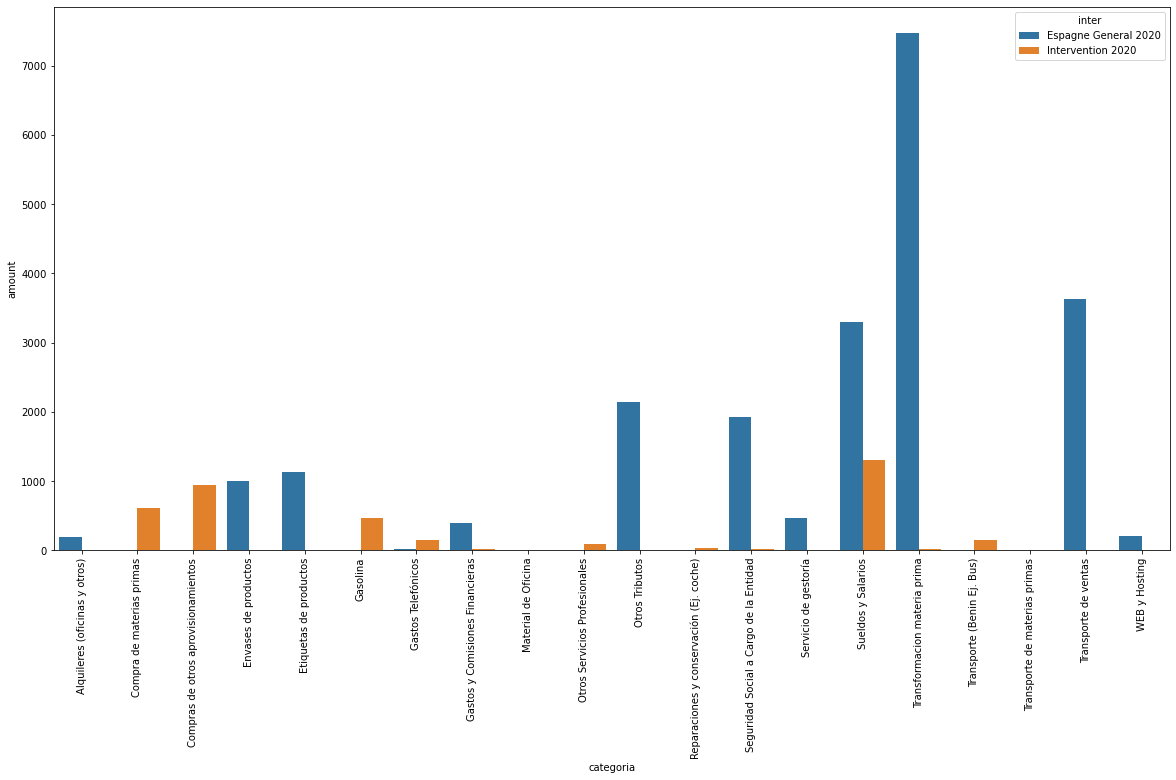

In [28]:
fig = plt.figure(figsize=(20,10))
ax = sns.barplot(x="categoria", y="amount",hue='inter', data=expense)
plt.xticks(rotation=90)
plt.show()

## INGRESOS Y GASTOS

In [29]:
df_3 = df_nikarit.groupby('type')['amount'].sum().reset_index()
df_3.head()

,type,amount
0,expense,25763.75
1,income,24030.30
2,movement,43167.60


In [30]:
df_3.iplot(kind='bar',x='type',y='amount')

## GASTOS

In [31]:
expense.inter.unique()

array(['Espagne General 2020', 'Intervention 2020'], dtype=object)

### NIKKI

In [32]:
expense[expense['inter']=='Intervention 2020']['amount'].sum()

3853.7599999999998

In [33]:
expense[expense['inter']=='Intervention 2020'].sort_values('amount',ascending=False)[['categoria','amount']]

,categoria,amount
29,Sueldos y Salarios,1310.27
9,Compras de otros aprovisionamientos,943.79
8,Compra de materias primas,613.42
15,Gasolina,474.98
17,Gastos Telefónicos,155.31
32,Transporte (Benin Ej. Bus),149.49
22,Otros Servicios Profesionales,91.44
24,Reparaciones y conservación (Ej. coche),40.40
26,Seguridad Social a Cargo de la Entidad,22.87
19,Gastos y Comisiones Financieras,15.98


In [34]:
expense[expense['inter']=='Intervention 2020'].sort_values('amount',ascending=False).iplot(kind='bar',x='categoria',y='amount',title='GASTOS NIKKI - 3853.75 €')

In [59]:
df_nikarit[(df_nikarit['inter']=='Intervention 2020') &
         (df_nikarit['categoria']=='Sueldos y Salarios')][['concept','amount','month_day','description']].sort_values('month_day')


,concept,amount,month_day,description
1368,Salaire / Personnelle,60.89,02-20,Salaires del mes de febrero 2020 de Younous y ...
1366,Salaire / Personnelle,22.83,02-27,"Salaire de Younous, Mireille et Lamatou pour l..."
1370,Salaire / Personnelle,45.66,03-12,"2 visites aux villages nouveaux avec Lamatou, ..."
1367,Salaire / Personnelle,91.33,03-31,Salaire pour voyage dans les villages
1372,Salaire / Personnelle,53.35,04-18,Salaire younouss et lamatou
1369,Salaire / Personnelle,91.33,04-30,Salaire mensuel
1364,entretien younouss,22.87,05-27,entretien de younouss pour voyager dans les vi...
1357,salaire mireille,121.95,06-01,salaire du mois de Mai
1089,salaire younouss,60.98,06-18,entretien de younouss du voyage sur parakou po...
1092,entretien younouss,15.24,06-20,salaire de younouss pour le voyage sur parakou...


Salaire / Personnelle	91.33	04-30	Salaire mensuel (ABRIL)
salaire mireille	121.95	06-01	salaire du mois de Mai
alaire mireille	182.93	07-10	salaire du mois de juin
salaire mireille	182.93	07-31	salaire du mois de juillet
Salaire / Personnelle	175.05	12-23	Salarios acumulados de Younous, Lamatou y Mire...


## ESPAÑA

In [60]:
expense[expense['inter']=='Espagne General 2020'].sort_values('amount',ascending=False)[['categoria','amount']]

,categoria,amount
30,Transformacion materia prima,7476.64
34,Transporte de ventas,3631.65
28,Sueldos y Salarios,3296.18
23,Otros Tributos,2149.46
25,Seguridad Social a Cargo de la Entidad,1930.91
14,Etiquetas de productos,1129.81
13,Envases de productos,1003.24
27,Servicio de gestoría,467.95
18,Gastos y Comisiones Financieras,391.27
36,WEB y Hosting,210.25


In [61]:
expense[expense['inter']=='Espagne General 2020']['amount'].sum()

21909.99

In [62]:
expense[expense['inter']=='Espagne General 2020'
       ].sort_values('amount',ascending=False
                    ).iplot(kind='bar',x='categoria',y='amount',title='Gastos Totales 21,909€'
                           )

In [63]:
df_nik_cat.categoria.unique()

array(['Alquileres (oficinas y otros)', 'Apertura',
       'Banco Caja de Ingenieros', 'Banco Paypal', 'Banco Santander',
       'Banco Stripe', 'Caja', 'Caja Mireille',
       'Compra de materias primas', 'Compras de otros aprovisionamientos',
       'Deudas a c.p. (Acreedores)', 'Deudas gastos de envio',
       'Donaciones', 'Envases de productos', 'Etiquetas de productos',
       'Gasolina', 'Gastos Telefónicos',
       'Gastos y Comisiones Financieras', 'Material de Oficina',
       'Otros Servicios Profesionales', 'Otros Tributos',
       'Reparaciones y conservación (Ej. coche)',
       'Seguridad Social a Cargo de la Entidad', 'Servicio de gestoría',
       'Sueldos y Salarios', 'Transformacion materia prima',
       'Transporte (Benin Ej. Bus)', 'Transporte de materias primas',
       'Transporte de ventas', 'Venta de Manteca de Karite',
       'WEB y Hosting'], dtype=object)

### ANALIZAR COMISIONES

In [64]:
df2=df_nikarit[(df_nikarit['inter']=='Espagne General 2020')&
                (df_nikarit['origin'] !='contoan' )].groupby('categoria')['amount'].sum().reset_index()

In [65]:
#Ingresos shopify
df2[df2['categoria']=='Venta de Manteca de Karite']['amount'].values[0]

11155.2

In [66]:
#Comisiones pagos en shopify
df2[df2['categoria']=='Gastos y Comisiones Financieras']['amount'].values[0]

336.7599999999999

In [67]:
#Ratio de comision
100*(df2[df2['categoria']=='Gastos y Comisiones Financieras']['amount'].values[0]
 /df2[df2['categoria']=='Venta de Manteca de Karite']['amount'].values[0])

3.018861158921399

In [68]:
df_nikarit['categoria'].unique()

array(['Venta de Manteca de Karite', 'Caja Mireille', 'Donaciones',
       'Banco Stripe', 'Apertura', 'Gastos y Comisiones Financieras',
       'Deudas gastos de envio', 'Caja', 'Banco Caja de Ingenieros',
       'Deudas a c.p. (Acreedores)', 'Banco Santander', 'Banco Paypal',
       'Otros Tributos', 'Transporte (Benin Ej. Bus)',
       'Compra de materias primas', 'Gasolina',
       'Reparaciones y conservación (Ej. coche)',
       'Transporte de materias primas',
       'Compras de otros aprovisionamientos', 'Sueldos y Salarios',
       'Seguridad Social a Cargo de la Entidad', 'Material de Oficina',
       'Gastos Telefónicos', 'Otros Servicios Profesionales',
       'WEB y Hosting', 'Transporte de ventas', 'Servicio de gestoría',
       'Envases de productos', 'Alquileres (oficinas y otros)',
       'Transformacion materia prima', 'Etiquetas de productos'],
      dtype=object)

In [69]:
df_nikarit[(df_nikarit['inter']=='Intervention 2020') &
         (df_nikarit['categoria']=='Compras de otros aprovisionamientos')][['concept','amount','month_day','description']].sort_values('month_day')

,concept,amount,month_day,description
1433,Achat de materiaux,24.35,02-24,Achat de 10 metres de tissus a 6.000 F le tota...
1362,Achat de materiaux,45.66,02-26,Achat d'une bascul de maximum 100 kilos pour p...
1432,Achat de materiaux,38.97,03-09,Compra de 12 metros de tela en el mercado a 72...
1434,Achat de materiaux,49.47,03-11,Compra de 56 metros de tela para el pedido de ...
1361,Achat de materiaux,96.12,03-17,Couture 421 petits sacs chez Kasim
1358,Carte d'identité,4.57,03-27,Carte d'identité
1360,Achat de materiaux,27.40,04-17,Achat de pneu
1102,achat matériels des femmes,334.15,06-20,achat des sacs pour emballer les amandes de ka...
1082,achats de gants,68.60,07-13,achats de gants pour les femmes de monnon
1084,achats aiguilles,7.62,07-13,achat aiguilles pours coudre les sacs


## ventas

In [70]:
sql = """
    SELECT *
    FROM `oan-nikarit.contoan.sales`
"""

# Run a Standard SQL query using the environment's default project
df_ventas = pd.read_gbq(sql, dialect='standard')

Downloading: 100%|██████████| 620/620 [00:01<00:00, 427.55rows/s]


In [71]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   close_date               539 non-null    datetime64[ns, UTC]
 1   creation_date            620 non-null    datetime64[ns, UTC]
 2   packContigo_unit_price   620 non-null    float64            
 3   gateway                  620 non-null    object             
 4   crema_total_price        620 non-null    int64              
 5   packHidra_unit_price     620 non-null    float64            
 6   crema_unit_price         620 non-null    float64            
 7   balsamo_total_price      620 non-null    int64              
 8   id                       620 non-null    object             
 9   total_tax                620 non-null    float64            
 10  longitude                562 non-null    float64            
 11  province                 537 non

In [72]:
df_ventas=df_ventas.sort_values('creation_date',
                                ascending=True).reset_index(drop=True)

In [105]:
(100*df_ventas['province'].value_counts()/537)[0:10]

Madrid        54.748603
Barcelona      5.586592
Valladolid     5.027933
Valencia       3.538175
Málaga         3.165736
A Coruña       2.793296
Cantabria      2.048417
Toledo         1.675978
Asturias       1.675978
Sevilla        1.675978
Name: province, dtype: float64

In [77]:
with open("/Users/daniel/OAN/credentials/shopify/parameters.yaml","r") as params:
    f = yaml.load(params, Loader=yaml.Loader)
    shop_url = f['ACCESS_URL']

In [79]:
orders = shop_url+'/orders.json'
r = requests.get(orders,
                 params={
                        'limit':250,
                        'status':'any',
                         'created_at_max':'2020-01-01T00:15:47-04:00'
                        })

In [80]:
all_orders = r.json()

In [81]:
orders2019 = pd.DataFrame(all_orders['orders'])

In [82]:
orders2019=orders2019.sort_values('created_at')

In [83]:
orders = shop_url+'/orders.json'
r = requests.get(orders,
                 params={
                        'limit':250,
                        'status':'any',
                         'created_at_max':'2020-05-01T00:15:47-04:00',
                         'created_at_min':'2020-01-01T00:15:47-04:00'
                        })

In [84]:
all_orders = r.json()

In [85]:
orders2020_1 = pd.DataFrame(all_orders['orders'])

In [86]:
len(orders2020_1)

230

In [87]:
orders2020_1=orders2020_1.sort_values('created_at')

In [88]:
orders = shop_url+'/orders.json'
r = requests.get(orders,
                 params={
                        'limit':250,
                        'status':'any',
                         'created_at_min':'2020-05-01T00:15:47-04:00'#,
                         #'created_at_min':'2020-01-01T00:15:47-04:00'
                        })

In [89]:
all_orders = r.json()

In [90]:
orders2020_2 = pd.DataFrame(all_orders['orders'])

In [91]:
len(orders2020_2)

149

In [92]:
orders2020_2=orders2020_2.sort_values('created_at')

In [93]:
df_orders = pd.concat([orders2019,orders2020_1,orders2020_2],axis=0).reset_index()

In [94]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 73 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   index                       607 non-null    int64 
 1   id                          607 non-null    int64 
 2   email                       607 non-null    object
 3   closed_at                   593 non-null    object
 4   created_at                  607 non-null    object
 5   updated_at                  607 non-null    object
 6   number                      607 non-null    int64 
 7   note                        0 non-null      object
 8   token                       607 non-null    object
 9   gateway                     607 non-null    object
 10  test                        607 non-null    bool  
 11  total_price                 607 non-null    object
 12  subtotal_price              607 non-null    object
 13  total_weight                607 non-null    int64 

In [95]:
df_ord = df_orders[['id', 'email', 'closed_at', 'created_at', 'total_price','subtotal_price',
           'total_tax','total_discounts','buyer_accepts_marketing', 'phone',
        'payment_gateway_names', 'line_items',
       'billing_address', 'shipping_address', 'client_details', 'customer',
       'payment_details']]

In [96]:
l_ship_det = ['ship_'+a for a in list(df_ord['shipping_address'][0].keys())]

In [97]:
df_ord[l_ship_det] = df_ord['shipping_address'].apply(lambda x: pd.Series(list(x.values()),index=l_ship_det))

In [98]:
df_ord['ship_zip']=df_ord['ship_zip'].fillna(value='')

In [ ]:
def update_firebase(x):
    order_id = x['order_id']
    if order_id==None :
        return True
    else:
        order_id = int(order_id)
    ship_zip=df_ord[df_ord['id']==order_id]['ship_zip'].values[0]
    fire_id=x['id']
    #print(x['creation_date'])
    #a=db.collection(u'Nikarit_Sales').document(x['id']).update({'zip':ship_zip})
    

In [ ]:
#df_ventas[df_ventas['origin']!='Contoan'].apply(lambda x: update_firebase(x),axis=1)

In [100]:
(100*df_ord['ship_province'].value_counts()/len(df_ord['ship_province'])).apply(lambda x: str(round(x,2))+'%')[0:10]

Madrid        51.24%
Barcelona       5.6%
Valladolid     5.27%
Valencia       3.95%
Málaga         3.13%
A Coruña       2.64%
Asturias       1.98%
Toledo         1.81%
Cantabria      1.81%
Sevilla        1.48%
Name: ship_province, dtype: object

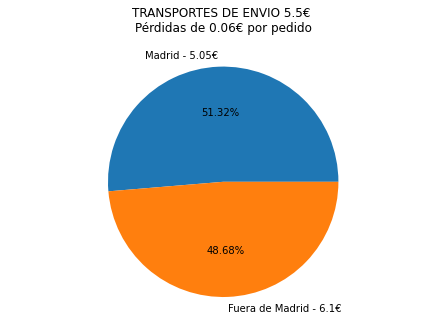

In [101]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ['Madrid - 5.05€', 'Fuera de Madrid - 6.1€']
students = [51.32,100-51.32]
ax.pie(students, labels = langs,autopct='%1.2f%%')
title= 'TRANSPORTES DE ENVIO 5.5€ \nPérdidas de {}€ por pedido'.format(abs(round(0.5132*(5.5-5.05)+(1-0.5132)*(5.5-6.1),2)))
plt.title(title)
plt.show()

In [106]:
counts=df_ord['email'].replace('',np.nan).dropna().value_counts().reset_index()
counts.columns=['email','counts']

In [107]:
email_counts = pd.merge(counts.reset_index(),
         df_ord[['email','ship_province']],
         on='email',how='left').drop('index',axis=1).drop_duplicates('email')

In [108]:
counts_total = email_counts['counts'].value_counts().sort_values(ascending=False)
counts_perc = (100*email_counts[
                                'counts'
                              ].value_counts().sort_values(
                                                            ascending=False
                                                         )
                               /len(email_counts['counts'])
              ).apply(lambda x:str(round(x,2))+'%')
                      
labels=['un solo pedido','dos pedidos','tres pedidos','cuatro pedidos','cinco pedidos','seis pedidos']
pd.DataFrame({'Numero de Pedidos x Cliente':labels,'Nº de Clientes':counts_total,'% total':counts_perc})

,Numero de Pedidos x Cliente,Nº de Clientes,% total
1,un solo pedido,454,89.02%
2,dos pedidos,40,7.84%
3,tres pedidos,13,2.55%
4,cuatro pedidos,1,0.2%
5,cinco pedidos,1,0.2%
6,seis pedidos,1,0.2%


Text(0, 0.5, 'counts')

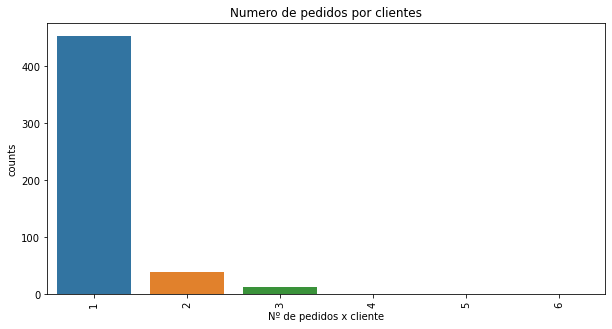

In [109]:
fig = plt.figure(figsize=(10,5))
sns.countplot('counts',data=email_counts.sort_values('counts'))
plt.xticks(rotation=90)
plt.title('Numero de pedidos por clientes')
plt.xlabel('Nº de pedidos x cliente')
plt.ylabel('counts')

### con latitud longitud

In [110]:
df_ord.apply(lambda x: str(x['ship_latitude'])+str(x['ship_latitude']),axis=1
            ).replace('nannan',np.nan).dropna().value_counts().value_counts()


1    487
2     23
3      4
8      1
dtype: int64

## en cuantas nos comemos el transporte

In [111]:
df_ventas.columns

Index(['close_date', 'creation_date', 'packContigo_unit_price', 'gateway',
       'crema_total_price', 'packHidra_unit_price', 'crema_unit_price',
       'balsamo_total_price', 'id', 'total_tax', 'longitude', 'province',
       'packContigo_nb', 'packHidra_nb', 'packHidra_total_price',
       'balsamo_unit_price', 'client_gender', 'order_id', 'client_email',
       'manteca_unit_price', 'origin', 'buyer_accepts_marketing', 'manteca_nb',
       'latitude', 'zip', 'manteca_total_price', 'accounting_item',
       'order_status_url', 'crema_nb', 'country', 'product_movement',
       'packContigo_total_price', 'subtotal_price', 'client_name',
       'taxes_included', 'client_last_name', 'total_price', 'balsamo_nb',
       'packAbanico_total_price', 'client_adresse', 'packAbanico_unit_price',
       'packBandana_total_price', 'bolsa_nb', 'city', 'packBandana_nb',
       'bolsa_total_price', 'packAbanico_nb', 'packBandana_unit_price',
       'client_phone', 'bolsa_unit_price'],
      dtype='o

50.0
38.0


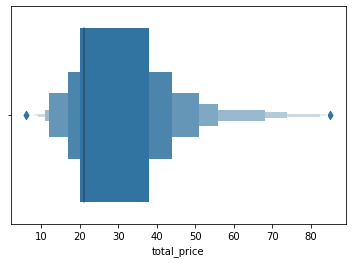

In [112]:
thres = df_ventas['total_price'].quantile(0.99)
sns.boxenplot(x=df_ventas[df_ventas['total_price']<thres]['total_price'])
print(df_ventas['total_price'].quantile(0.90))
print(df_ventas['total_price'].quantile(0.75))
plt.show()

Text(0.5, 1.0, 'Histograma de precios/ingresos de los pedidos\n (sin right_outliers)')

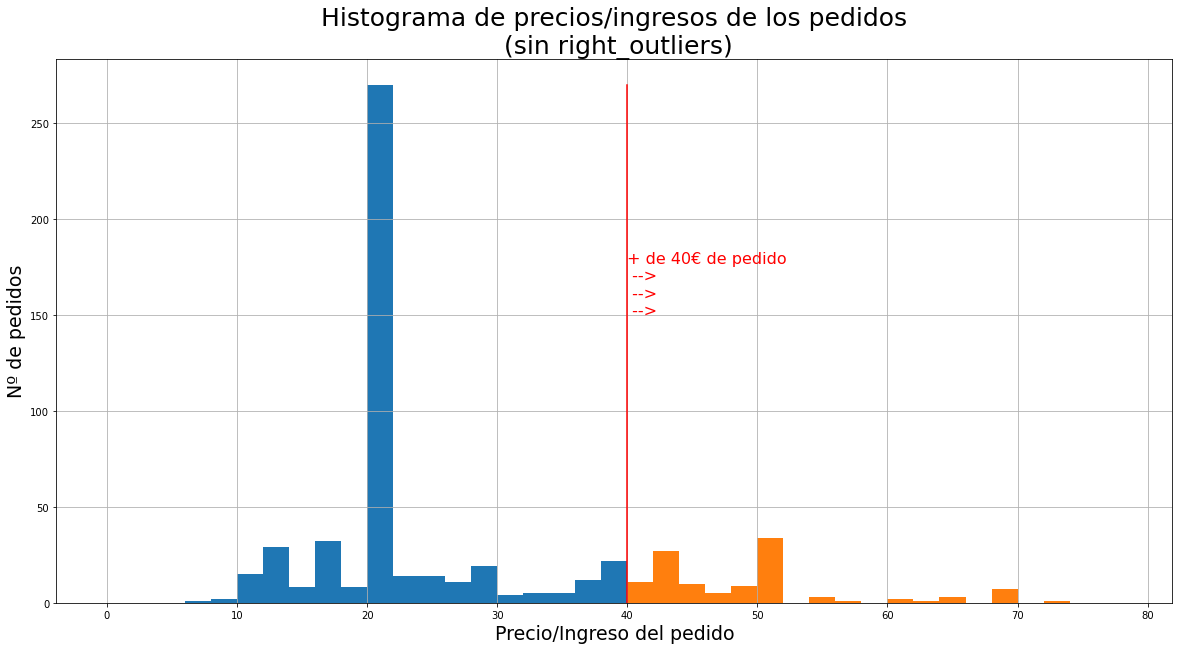

In [113]:
thres = df_ventas['total_price'].quantile(0.98)
#total_price=df_ventas[df_ventas['total_price']<thres]['total_price']
df_ventas[df_ventas['total_price']<40]['total_price'].hist(bins=np.arange(0,41,2),figsize=(20,10))
df_ventas[df_ventas['total_price']>40]['total_price'].hist(bins=np.arange(40,80,2),figsize=(20,10))
plt.xlabel('Precio/Ingreso del pedido',fontsize=19)
plt.ylabel('Nº de pedidos',fontsize=19)
plt.plot(40*np.ones(10),30*np.arange(10),color='r')
plt.text(40,150,'+ de 40€ de pedido\n -->\n -->\n -->',fontsize=16,color='r')
plt.title('Histograma de precios/ingresos de los pedidos\n (sin right_outliers)',fontsize=25)

In [114]:
thres=40
len(df_ventas)
len(df_ventas[df_ventas['total_price']<thres]['total_price'])/len(df_ventas)

0.7596774193548387

In [115]:
len(df_ventas[df_ventas['total_price']>=thres]['total_price'])/len(df_ventas)

0.2403225806451613

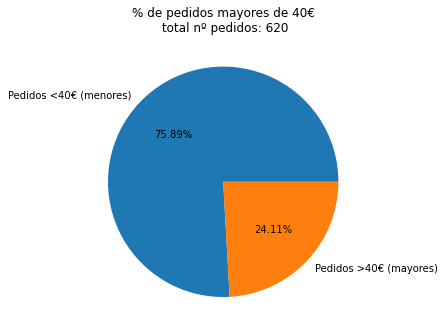

In [116]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ['Pedidos <40€ (menores)', 'Pedidos >40€ (mayores)']
students = [75.889,24.11]
ax.pie(students, labels = langs,autopct='%1.2f%%')
title= '% de pedidos mayores de 40€\n total nº pedidos: {}'.format(len(df_ventas))
plt.title(title)
plt.show()

In [117]:
df_ventas.apply(lambda x:
                ((str(x['crema_nb'])+'_cre||'
                 )+(str(x['balsamo_nb'])+'_bal||'
                 )+(str(x['manteca_nb'])+'_mant||'
                 )+(str(x['packHidra_nb'])+'_packH||'
                 )+(str(x['packContigo_nb'])+'_packC'
                 )
                 ),axis=1
               ).value_counts()[0:20]

0_cre||0_bal||0_mant||1_packH||0_packC    282
0_cre||0_bal||1_mant||0_packH||0_packC     43
0_cre||0_bal||0_mant||3_packH||0_packC     38
0_cre||0_bal||0_mant||2_packH||0_packC     33
0_cre||0_bal||2_mant||0_packH||0_packC     18
0_cre||0_bal||1_mant||2_packH||0_packC     17
0_cre||0_bal||1_mant||1_packH||0_packC     13
0_cre||0_bal||3_mant||0_packH||0_packC     12
0_cre||0_bal||5_mant||0_packH||0_packC     10
0_cre||0_bal||0_mant||4_packH||0_packC      9
0_cre||1_bal||2_mant||0_packH||0_packC      8
0_cre||1_bal||1_mant||0_packH||0_packC      7
1_cre||0_bal||0_mant||2_packH||0_packC      7
0_cre||0_bal||3_mant||1_packH||0_packC      6
0_cre||0_bal||6_mant||0_packH||0_packC      6
0_cre||0_bal||0_mant||0_packH||1_packC      5
1_cre||0_bal||0_mant||1_packH||0_packC      4
0_cre||0_bal||0_mant||2_packH||1_packC      4
1_cre||0_bal||1_mant||0_packH||0_packC      4
2_cre||0_bal||0_mant||0_packH||0_packC      4
dtype: int64

Text(0, 0.5, 'precios')

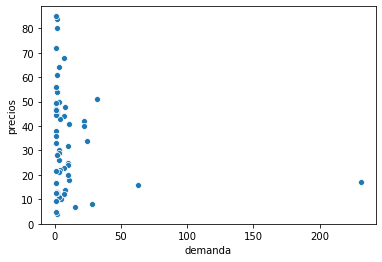

In [118]:
#precios y demanda gráficos
demand_plot = df_ventas[df_ventas['subtotal_price']<100]['subtotal_price'].value_counts().reset_index()
sns.scatterplot(x='subtotal_price',y='index',data=demand_plot)
plt.xlabel('demanda')
plt.ylabel('precios')

## HOW MUCH MONEY DO WE LOOSE

In [119]:
df_ventas['subtotal_price']=pd.to_numeric(df_ventas['subtotal_price'])

In [120]:
thres = df_ventas['subtotal_price'].quantile(0.97)
print(thres)
total_price=df_ventas[df_ventas['subtotal_price']<thres]['subtotal_price']
print(len(total_price))
total_revenue=total_price.sum()
total_revenue

68.0
600


14215.7

In [121]:
thres=40
lost_transport=5.56*0.25*len(total_price)
lost_transport

833.9999999999999

Text(0, 0.5, '€')

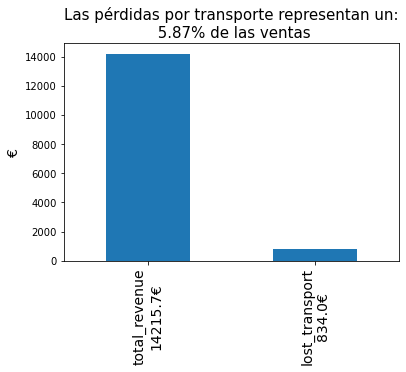

In [122]:
labels=['total_revenue\n{}€'.format(round(total_revenue,2)),
        'lost_transport\n{}€'.format(round(lost_transport,2))
                                  ]
bar_to_plot = pd.DataFrame({'lab':labels,
                            'val':[total_revenue,lost_transport]})
ax = bar_to_plot.plot(x='lab', y='val', kind='bar')
ax.get_legend().remove()
ax.set_title(
    'Las pérdidas por transporte representan un:\n {}% de las ventas'.format(
                            round(100*(lost_transport/total_revenue),2)),
    fontsize=15
        )
ax.set_xlabel('')
plt.xticks(fontsize=14)
ax.set_ylabel('€',fontsize=14)

### comisiones financieras

In [123]:
def comisiones(x):
    gateway = x['gateway']
    if gateway== 'shopify_payments':
        return x['total_price']*0.021+0.25
    elif gateway== 'paypal':
        return x['total_price']*0.019+0.35
    else:
        print('error')
        print(gateway)
    return 0

In [124]:
#comisiones
df_ventas_shop = df_ventas[
                           #(df_ventas['origin'] != 'Contoan') &
                           #(df_ventas['gateway'] != 'shopify_payments')]
                           #(df_ventas['gateway'] != 'paypal')]
                          (df_ventas['origin'] != 'Contoan')]
total_comisiones=df_ventas_shop.apply(lambda x: comisiones(x),axis=1).sum()
total_comisiones

555.05675

In [125]:
total_sin_trans = df_ventas_shop['subtotal_price'].sum()
total_sin_trans

16880.25

In [126]:
100*total_comisiones/total_sin_trans

3.288202188948623

Text(0, 0.5, '€')

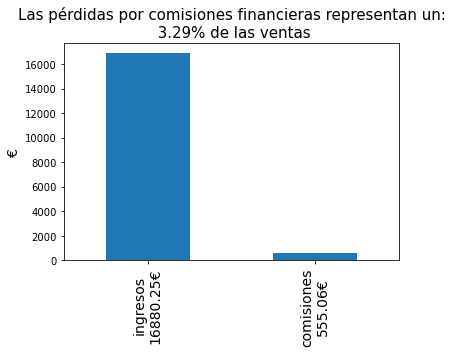

In [127]:
labels=['ingresos\n{}€'.format(round(total_sin_trans,2)),
        'comisiones\n{}€'.format(round(total_comisiones,2))
                                  ]
bar_to_plot = pd.DataFrame({'lab':labels,
                            'val':[total_sin_trans,total_comisiones]})
ax = bar_to_plot.plot(x='lab', y='val', kind='bar')
ax.get_legend().remove()
ax.set_title(
    'Las pérdidas por comisiones financieras representan un:\n {}% de las ventas'.format(
                            round(100*total_comisiones/total_sin_trans,2)),
    fontsize=15
        )
ax.set_xlabel('')
plt.xticks(fontsize=14)
ax.set_ylabel('€',fontsize=14)

Etiquetas (x2)		0.13 €
Envase+envasado+materia prima		1.16 €
Cajas		0.32 €

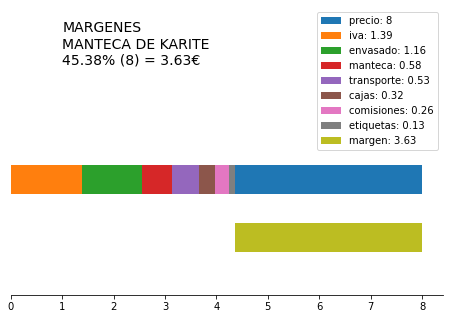

In [129]:
#MANTECAS
fig = plt.figure()
ax = fig.add_axes((1,1,1,1))
precio=8
width=0.1
#comisiones
p1 = ax.barh([1],[precio],width,label='precio: {}'.format(precio))

#IVA
iva=round(precio*(1-1/1.21),2)
p2 = ax.barh([1],[iva],width,left=0,label='iva: {}'.format(iva))

#ENVASADO
envasado=1.16
left=iva
p3 = ax.barh([1],[envasado],width,left=left,label='envasado: {}'.format(envasado))


#COSTE MANTECA
manteca=0.58
left=left+envasado
p3 = ax.barh([1],[manteca],width,left=left,label='manteca: {}'.format(manteca))


#transporte gratuito y pedidos fuera de madrid
transporte=round(precio*0.0586+0.06,2)
left=left+manteca
p4 = ax.barh([1],[transporte],width,left=left,label='transporte: {}'.format(transporte))

#cajas
cajas=0.32
left=left+transporte
p6 = ax.barh([1],[cajas],width,left=left,label='cajas: {}'.format(cajas))

#comisiones
comisiones=round(precio*0.033,2)
left=left+cajas
p5 = ax.barh([1],[comisiones],width,left=left,label='comisiones: {}'.format(comisiones))

#etiquetas
etiquetas=0.13
left=left+comisiones
p7 = ax.barh([1],[etiquetas],width,left=left,label='etiquetas: {}'.format(etiquetas))

#margen
left=left+etiquetas
margen=precio-left
p8 = ax.barh([0.8],[margen],width,left=left,label='margen: {}'.format(margen))

costes_pack1=etiquetas+envasado+manteca

perc_margen = round(100*margen/precio,2)

text='MARGENES\nMANTECA DE KARITE\n{}% (8) = {}€'.format(perc_margen,margen)
plt.text(1,1.4,text,fontsize=14)

plt.ylim(0.6,1.6)
ax.set_yticks([])
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.legend()

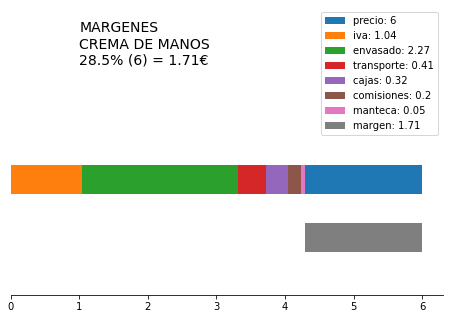

In [130]:
#CREMAS
fig = plt.figure()
ax = fig.add_axes((1,1,1,1))
precio=6
width=0.1
#comisiones
p1 = ax.barh([1],[precio],width,label='precio: {}'.format(precio))

#IVA
iva=round(precio*(1-1/1.21),2)
p2 = ax.barh([1],[iva],width,left=0,label='iva: {}'.format(iva))

#ENVASADO
envasado=2.27
left=iva
p3 = ax.barh([1],[envasado],width,left=left,label='envasado: {}'.format(envasado))
env2=envasado


#transporte gratuito y pedidos fuera de madrid
transporte=round(precio*0.0586+0.06,2)
left=left+envasado
p4 = ax.barh([1],[transporte],width,left=left,label='transporte: {}'.format(transporte))

#cajas
cajas=0.32
left=left+transporte
p6 = ax.barh([1],[cajas],width,left=left,label='cajas: {}'.format(cajas))

#comisiones
comisiones=round(precio*0.033,2)
left=left+cajas
p5 = ax.barh([1],[comisiones],width,left=left,label='comisiones: {}'.format(comisiones))

#COSTE MANTECA
manteca=0.05
left=left+comisiones
p3 = ax.barh([1],[manteca],width,left=left,label='manteca: {}'.format(manteca))

#margen
left=left+manteca
margen=round(precio-left,2)
p8 = ax.barh([0.8],[margen],width,left=left,label='margen: {}'.format(margen))

costes_pack2=envasado+manteca

perc_margen = round(100*margen/precio,2)

text='MARGENES\nCREMA DE MANOS\n{}% (6) = {}€'.format(perc_margen,margen)
plt.text(1,1.4,text,fontsize=14)

plt.ylim(0.6,1.6)
ax.set_yticks([])
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.legend()

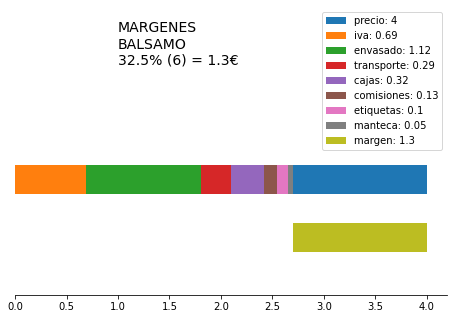

In [131]:
#BALSAMOS
fig = plt.figure()
ax = fig.add_axes((1,1,1,1))
precio=4
width=0.1
#comisiones
p1 = ax.barh([1],[precio],width,label='precio: {}'.format(precio))

#IVA
iva=round(precio*(1-1/1.21),2)
p2 = ax.barh([1],[iva],width,left=0,label='iva: {}'.format(iva))

#ENVASADO
envasado=1.12
left=iva
p3 = ax.barh([1],[envasado],width,left=left,label='envasado: {}'.format(envasado))
env3=envasado


#transporte gratuito y pedidos fuera de madrid
transporte=round(precio*0.0586+0.06,2)
left=left+envasado
p4 = ax.barh([1],[transporte],width,left=left,label='transporte: {}'.format(transporte))

#cajas
cajas=0.32
left=left+transporte
p6 = ax.barh([1],[cajas],width,left=left,label='cajas: {}'.format(cajas))

#comisiones
comisiones=round(precio*0.033,2)
left=left+cajas
p5 = ax.barh([1],[comisiones],width,left=left,label='comisiones: {}'.format(comisiones))

#etiquetas
etiquetas=0.1
left=left+comisiones
p7 = ax.barh([1],[etiquetas],width,left=left,label='etiquetas: {}'.format(etiquetas))

#COSTE MANTECA
manteca=0.05
left=left+etiquetas
p3 = ax.barh([1],[manteca],width,left=left,label='manteca: {}'.format(manteca))

#margen
left=left+manteca
margen=round(precio-left,2)
p8 = ax.barh([0.8],[margen],width,left=left,label='margen: {}'.format(margen))

costes_pack3=etiquetas+envasado+manteca

perc_margen = round(100*margen/precio,2)

text='MARGENES\nBALSAMO\n{}% (6) = {}€'.format(perc_margen,margen)
plt.text(1,1.4,text,fontsize=14)

plt.ylim(0.6,1.6)
ax.set_yticks([])
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.legend()

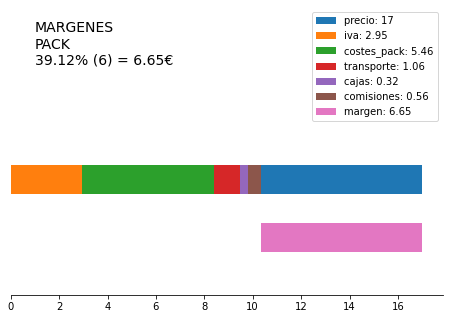

In [132]:
#PACK + HIDRATADA
fig = plt.figure()
ax = fig.add_axes((1,1,1,1))
precio=17
width=0.1
#precio
p1 = ax.barh([1],[precio],width,label='precio: {}'.format(precio))

#IVA
iva=round(precio*(1-1/1.21),2)
p2 = ax.barh([1],[iva],width,left=0,label='iva: {}'.format(iva))

#ENVASADO Y MANTECA
costes_pack=costes_pack1+costes_pack2+costes_pack3
left=iva
p3 = ax.barh([1],[costes_pack],width,left=left,label='costes_pack: {}'.format(costes_pack))


#transporte gratuito y pedidos fuera de madrid
transporte=round(precio*0.0586+0.06,2)
left=left+costes_pack
p4 = ax.barh([1],[transporte],width,left=left,label='transporte: {}'.format(transporte))

#cajas
cajas=0.32
left=left+transporte
p6 = ax.barh([1],[cajas],width,left=left,label='cajas: {}'.format(cajas))

#comisiones
comisiones=round(precio*0.033,2)
left=left+cajas
p5 = ax.barh([1],[comisiones],width,left=left,label='comisiones: {}'.format(comisiones))

#margen
left=left+comisiones
margen=round(precio-left,2)
p8 = ax.barh([0.8],[margen],width,left=left,label='margen: {}'.format(margen))

costes_pack3=etiquetas+envasado+manteca

perc_margen = round(100*margen/precio,2)

text='MARGENES\nPACK\n{}% (6) = {}€'.format(perc_margen,margen)
plt.text(1,1.4,text,fontsize=14)

plt.ylim(0.6,1.6)
ax.set_yticks([])
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.legend()

In [133]:
total=df_ventas.apply(lambda x:
                ((str(x['crema_nb'])+'_cre||'
                 )+(str(x['balsamo_nb'])+'_bal||'
                 )+(str(x['manteca_nb'])+'_mant||'
                 )+(str(x['packHidra_nb'])+'_packH||'
                 )+(str(x['packContigo_nb'])+'_packC'
                 )
                 ),axis=1
               ).value_counts()[0:10].sum()
print(total)
sales_dist=df_ventas.apply(lambda x:
                ((str(x['crema_nb'])+'_cre||'
                 )+(str(x['balsamo_nb'])+'_bal||'
                 )+(str(x['manteca_nb'])+'_mant||'
                 )+(str(x['packHidra_nb'])+'_packH||'
                 )+(str(x['packContigo_nb'])+'_packC'
                 )
                 ),axis=1
               ).value_counts()[0:10]/total
sales_dist

475


0_cre||0_bal||0_mant||1_packH||0_packC    0.593684
0_cre||0_bal||1_mant||0_packH||0_packC    0.090526
0_cre||0_bal||0_mant||3_packH||0_packC    0.080000
0_cre||0_bal||0_mant||2_packH||0_packC    0.069474
0_cre||0_bal||2_mant||0_packH||0_packC    0.037895
0_cre||0_bal||1_mant||2_packH||0_packC    0.035789
0_cre||0_bal||1_mant||1_packH||0_packC    0.027368
0_cre||0_bal||3_mant||0_packH||0_packC    0.025263
0_cre||0_bal||5_mant||0_packH||0_packC    0.021053
0_cre||0_bal||0_mant||4_packH||0_packC    0.018947
dtype: float64

MANTECA: 45.4%
CREMA: 28.5%
BALSAMO: 32.5%
PACK: 39.1%

In [134]:
labels = ['1pack','1manteca','3packs','2packs','2mantecas','1mateca_2packs','1mateca_1packs',
         '3matecas','5matecas','4packs']

marg = [0.391,0.454,0.391,0.391,0.454,0.412,0.4225,0.454,0.454,0.391] 

mantecas = [0,1,0,0,2,1,1,3,5,0]
packs = [1,0,3,2,0,2,1,0,0,4]

margenes = pd.DataFrame({'ventas mas comunes':labels,
                         'mantecas':mantecas,
                         'packs':packs,
                         '% recurrencia':sales_dist,
                         'margenes':marg}).reset_index(drop=True)
margenes

,ventas mas comunes,mantecas,packs,% recurrencia,margenes
0,1pack,0,1,0.593684,0.3910
1,1manteca,1,0,0.090526,0.4540
2,3packs,0,3,0.080000,0.3910
3,2packs,0,2,0.069474,0.3910
4,2mantecas,2,0,0.037895,0.4540
5,1mateca_2packs,1,2,0.035789,0.4120
6,1mateca_1packs,1,1,0.027368,0.4225
7,3matecas,3,0,0.025263,0.4540
8,5matecas,5,0,0.021053,0.4540
9,4packs,0,4,0.018947,0.3910


In [135]:
margenes['precio']=margenes['mantecas']*10+margenes['packs']*18

In [136]:
(margenes['margenes']*margenes['% recurrencia']).sum()/margenes['% recurrencia'].sum()

0.40362210526315795

# OBJETIVO DE VENTAS

In [137]:
# COSTES FIJOS EN NIKKI 600€
600/0.40362210526315795

1486.5389981770336

In [138]:
margenes['ventas']=margenes['% recurrencia']*1500

In [139]:
margenes['beneficios']=margenes['ventas']*margenes['margenes']

In [140]:
margenes['packs_total'] = margenes['packs']*margenes['ventas']/(margenes['precio'])

In [141]:
margenes['mantecas_total'] =margenes['mantecas']*margenes['ventas']/(margenes['precio'])

In [142]:
margenes=margenes.replace(np.nan,0)

In [143]:
margenes['mantecas_total'] = margenes['mantecas_total']
margenes['packs_total'] = margenes['packs_total']

In [144]:
margenes['% recurrencia']=margenes['% recurrencia'].apply(lambda x:str(round(100*x,2))+'%')

In [145]:
margenes

,ventas mas comunes,mantecas,packs,% recurrencia,margenes,precio,ventas,beneficios,packs_total,mantecas_total
0,1pack,0,1,59.37%,0.3910,18,890.526316,348.195789,49.473684,0.000000
1,1manteca,1,0,9.05%,0.4540,10,135.789474,61.648421,0.000000,13.578947
2,3packs,0,3,8.0%,0.3910,54,120.000000,46.920000,6.666667,0.000000
3,2packs,0,2,6.95%,0.3910,36,104.210526,40.746316,5.789474,0.000000
4,2mantecas,2,0,3.79%,0.4540,20,56.842105,25.806316,0.000000,5.684211
5,1mateca_2packs,1,2,3.58%,0.4120,46,53.684211,22.117895,2.334096,1.167048
6,1mateca_1packs,1,1,2.74%,0.4225,28,41.052632,17.344737,1.466165,1.466165
7,3matecas,3,0,2.53%,0.4540,30,37.894737,17.204211,0.000000,3.789474
8,5matecas,5,0,2.11%,0.4540,50,31.578947,14.336842,0.000000,3.157895
9,4packs,0,4,1.89%,0.3910,72,28.421053,11.112632,1.578947,0.000000


## 18€ packs y 10€ mantecas

In [146]:
print('Estadisticas mensuales')
margenes[['mantecas_total','packs_total','ventas','beneficios']].sum()

Estadisticas mensuales


mantecas_total      28.843740
packs_total         67.309033
ventas            1500.000000
beneficios         605.433158
dtype: float64

In [147]:
print('Estadisticas diarias')
margenes[['mantecas_total','packs_total','ventas','beneficios']].sum()/30

Estadisticas diarias


mantecas_total     0.961458
packs_total        2.243634
ventas            50.000000
beneficios        20.181105
dtype: float64